# **Using four recurrent neural network architecture with support vector machine to detect and understand human emotions in text-based data set.**

**RNN(LSTM, GRU, Bidirectional LSTM and Bidirectional GRU)-SVM models**

This product has 9 stages to detect and analysis positive and negative Twitter tweets. These nine stages are Load the Data Set, Text Preprocessing, Splitting the Data Set, Tokenisation, Label Encoding, Pretrained GloVe word embedding, Training the hybrid models (LSTM-SVM, GRU-SVM, Bi_LSTM-SVM, Bi_GRU-SVM), Accuracy Analysis and Testing Class.

**Importing the necessary libraries**

In [58]:

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import string
import itertools
import re

from wordcloud import WordCloud

import nltk 
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
from tensorflow.keras.losses import Hinge
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PMLS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Activating the Kaggle OS path for data set retrieval**

In [59]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**Using the TensorFlow-GPU version instead of the CPU version**

In [60]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  0


# Stage 1: Load the Data Set

In [61]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin', header=None)
data.head(5)

0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

**Data set Examination**

In [62]:
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
data.head(5)

sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

           user_id                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [63]:
list(data.columns.values)

['sentiment', 'id', 'date', 'query', 'user_id', 'text']

In [64]:
data.shape

(1600000, 6)

In [65]:
data.count()

sentiment    1600000
id           1600000
date         1600000
query        1600000
user_id      1600000
text         1600000
dtype: int64

In [66]:
data.dtypes

sentiment     int64
id            int64
date         object
query        object
user_id      object
text         object
dtype: object

In [67]:
sentiment_counts = data.sentiment.value_counts()
print(sentiment_counts)

sentiment
0    800000
4    800000
Name: count, dtype: int64


In [68]:
text_counts = data.text.value_counts()
print(text_counts)

text
isPlayer Has Died! Sorry                                                                              210
good morning                                                                                          118
headache                                                                                              115
Good morning                                                                                          112
Headache                                                                                              106
                                                                                                     ... 
braces  tell me it will be okay...                                                                      1
is stuck at home without curry                                                                          1
@mrsduryee I've applied to about 70 since I lost my job in March...it certainly FEELS like a lot!       1
The cheese I got @SarawithanR lost its sq

In [69]:
data.describe()

sentiment            id
count  1.600000e+06  1.600000e+06
mean   2.000000e+00  1.998818e+09
std    2.000001e+00  1.935761e+08
min    0.000000e+00  1.467810e+09
25%    0.000000e+00  1.956916e+09
50%    2.000000e+00  2.002102e+09
75%    4.000000e+00  2.177059e+09
max    4.000000e+00  2.329206e+09

Visual representation of the data

<Axes: xlabel='sentiment'>

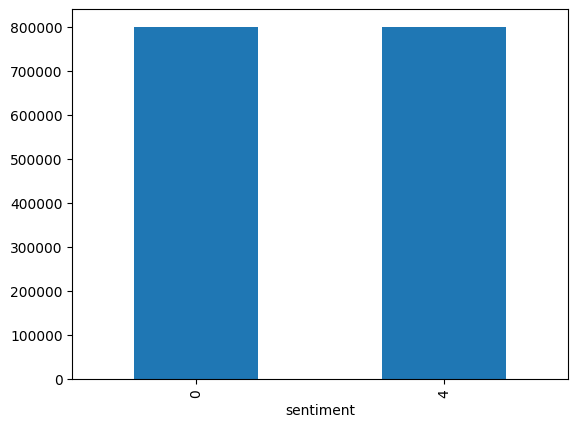

In [70]:
data['sentiment'].value_counts().plot(kind='bar')

#plt.savefig('img/data_set_1_sentiment_bar_chart.png', format='png')

<Axes: ylabel='count'>

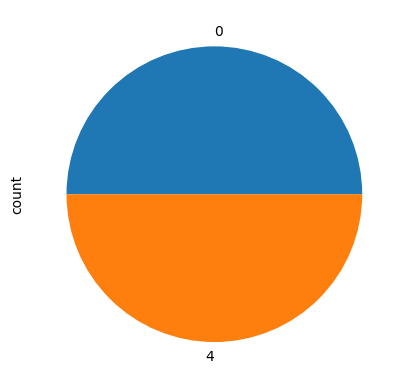

In [71]:
data['sentiment'].value_counts().plot(kind='pie')

#plt.savefig('img/data_set_1_sentiment_pie_chart.png', format='png')

**Text and sentiment columns are kept while the rest are dropped**

In [72]:
data = data.drop(['id', 'date', 'query', 'user_id'], axis=1)

encoded_data = data

**Assigning label numbers with positive and negative traits**

In [73]:
labels_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
    return labels_to_sentiment[label]
    encoded_data.sentiment = encoded_data.sentiment.apply(lambda x: label_decoder(x))
encoded_data.head(5)

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

Checking the distribution of the data before the reduction phase

Text(0.5, 1.0, '1.6 Million Twitter Tweets Sentiment Data Distribution')

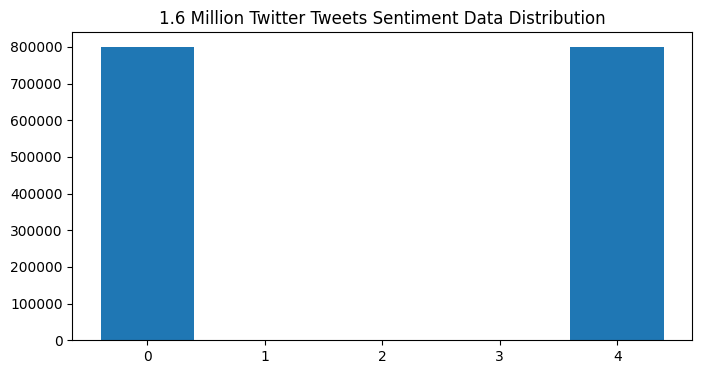

In [74]:
val_count = encoded_data.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("1.6 Million Twitter Tweets Sentiment Data Distribution")

#plt.savefig('img/data_set_1_distribution_bar_chart.png', format='png')

**Reducing the data set**

* Reasons: Hardware GPU power limitation and creating an equal data set to compare it against another product prototype.

In [75]:
reduced_data = encoded_data
reduced_data.head(5)

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

Separating the positive and negative rows

In [76]:
data_positive = reduced_data[reduced_data['sentiment'] == 4]
data_negative = reduced_data[reduced_data['sentiment'] == 0]
print(len(data_positive), len(data_negative))

800000 800000


Dividing the data set into an equal amount

In [77]:
data_positive = data_positive.iloc[:int(len(data_positive)/80)]
data_negative = data_negative.iloc[:int(len(data_negative)/80)]
print(len(data_positive), len(data_negative))

10000 10000


Joining both the data sets back together

In [78]:
reduced_data = pd.concat([data_positive, data_negative])
len(reduced_data)

20000

**Displaying the most used words in the positive and negative sentiment labels**

In [79]:
cleaned_data = reduced_data
cleaned_data.head(5)

sentiment                                               text
800000          4       I LOVE @Health4UandPets u guys r the best!! 
800001          4  im meeting up with one of my besties tonight! ...
800002          4  @DaRealSunisaKim Thanks for the Twitter add, S...
800003          4  Being sick can be really cheap when it hurts t...
800004          4    @LovesBrooklyn2 he has that effect on everyone

Positive words

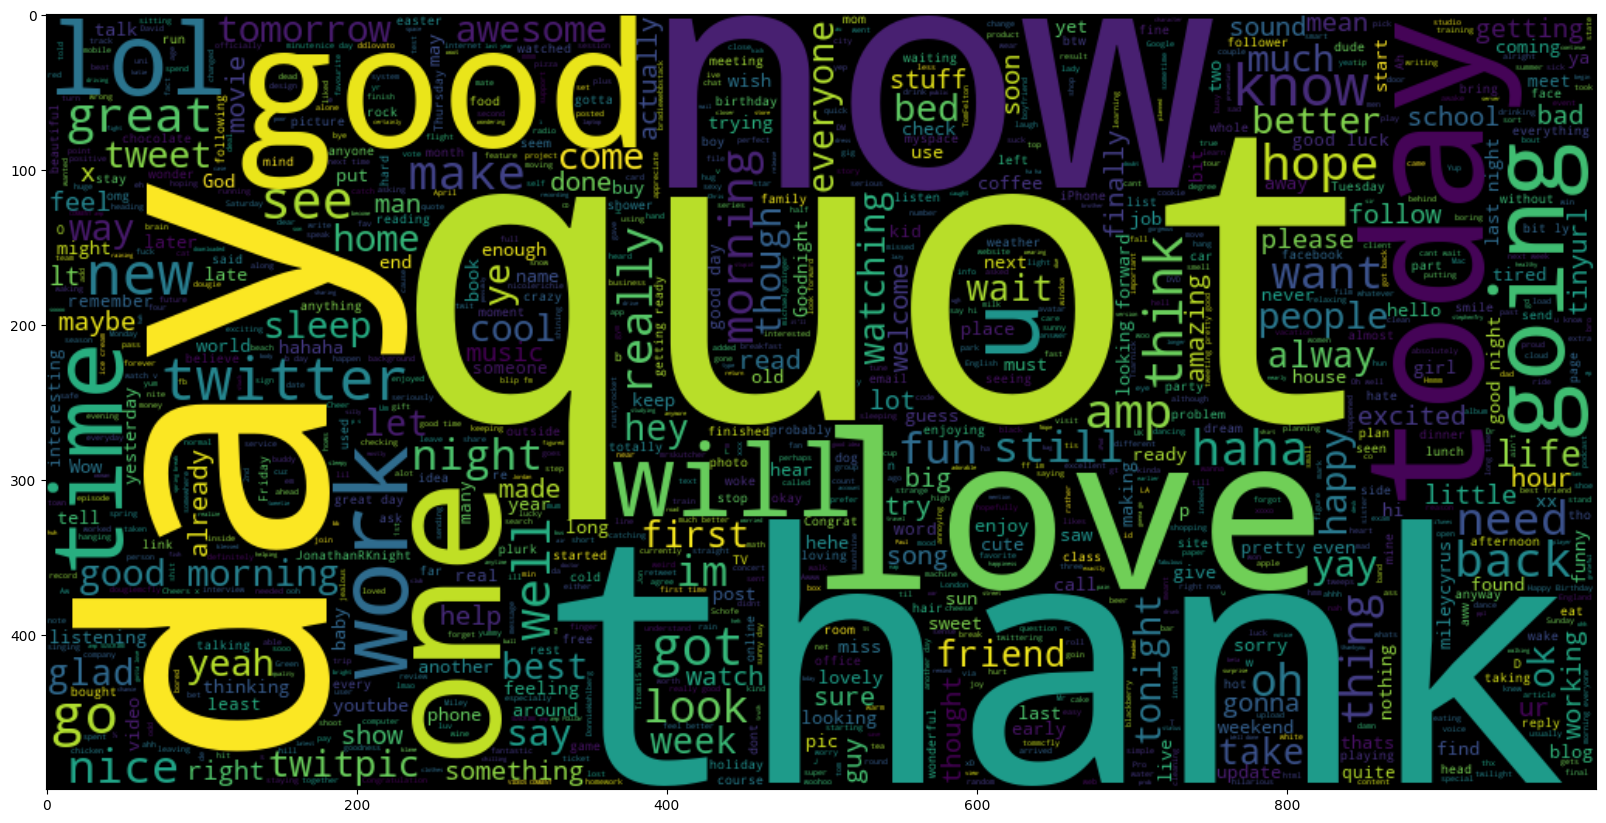

In [80]:
plt.figure(figsize = (20,20)) 
Positive_WC = WordCloud(max_words = 1000 , width = 1000 , height = 500).generate(" ".join(cleaned_data[cleaned_data.sentiment == 4].text))
plt.imshow(Positive_WC , interpolation = 'bilinear')

#plt.savefig('img/data_set_1_positive_words.png', format='png')

Negative words

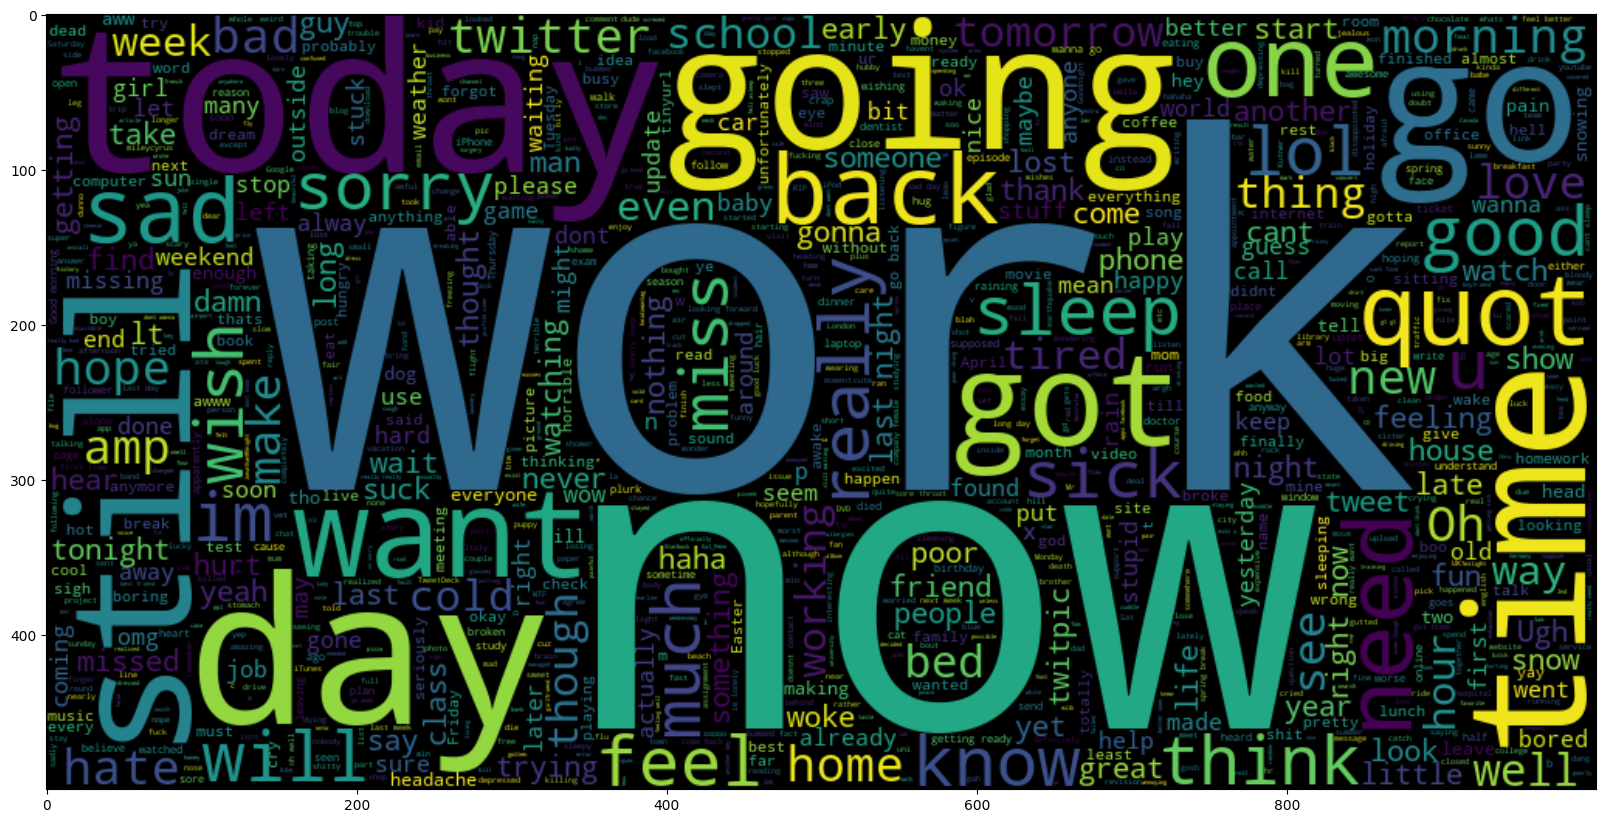

In [81]:
plt.figure(figsize = (20,20)) 
Negative_WC = WordCloud(max_words = 1000 , width = 1000 , height = 500).generate(" ".join(cleaned_data[cleaned_data.sentiment == 0].text))
plt.imshow(Negative_WC , interpolation = 'bilinear')

#plt.savefig('img/data_set_1_negative_words.png', format='png')

# Stage 2: Text Preprocessing

Removing URL and HTML

In [82]:
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

Removing any leftovers of unnecessary texts

In [83]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"    

def text_cleaning(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    return text

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\PMLS\AppData\Local\Temp\ipykernel_11252\1257922648.py:1: SyntaxWarning: invalid escape sequence '\S'
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


Removing integers

In [84]:
def number_cleaning(text):
    text = ''.join(c for c in text if not c.isdigit())
    return text

Removing emojis

In [85]:
def remove_emoji(string):
    emoji_pattern = re.compile(
    "["
        u"\U0001F600-\U0001F64F" #emoticons
        u"\U0001F300-\U0001F5FF" #symbols & pictographs
        u"\U0001F680-\U0001F6FF" #transport & map symbols
        u"\U0001F1E0-\U0001F1FF" #FLAGS on (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

Removing punctuation

In [86]:
def remove_punctuation(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

Stemming the text using the Porter version

In [87]:
def stemming_words(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

Removing stopwords

In [88]:
stop = set(stopwords.words("english"))

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    
    return " ".join(text)

**Applying text preprocessing**

In [89]:
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_URL(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_html(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: text_cleaning(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: number_cleaning(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_emoji(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_punctuation(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: stemming_words(x))
cleaned_data["text"] = cleaned_data["text"].apply(remove_stopwords)

**Viewing the cleaned data**

In [90]:
cleaned_data.head(5)

sentiment                                               text
800000          4                    love healthuandpet u guy r best
800001          4      im meet one besti tonight cant wait girl talk
800002          4  thank twitter add sunisa got meet onc hin show...
800003          4  sick realli cheap hurt much eat real food plu ...
800004          4                                  ha effect everyon

In [91]:
cleaned_data.text

800000                      love healthuandpet u guy r best
800001        im meet one besti tonight cant wait girl talk
800002    thank twitter add sunisa got meet onc hin show...
800003    sick realli cheap hurt much eat real food plu ...
800004                                    ha effect everyon
                                ...                        
9995                                                aww sad
9996                           stupid dvd stuf good bit jaw
9997      onli close friend famili afraid onli work coll...
9998                    crap look last tweet whi earli like
9999                                     anoth rainboot day
Name: text, Length: 20000, dtype: object

# Stage 3: Splitting the Data Set

In [92]:
train_size = 0.8

Splitting the data set into 80% training and 20% testing set then randomise it for balance purpose

In [93]:
train_data, test_data = train_test_split(cleaned_data, test_size=1-train_size, random_state=7) 

print("Train data size:", len(train_data))
print("Test data size", len(test_data))

Train data size: 16000
Test data size 4000


In [94]:
train_data.head(10)

sentiment                                               text
808118          4                agre conversationag ha great inform
171             0                                       current work
809399          4                homework day assign due almost done
2669            0   ear size hurt watch chao theori wonder movi love
8809            0             empir onli band song thing upload site
3869            0                  thi lost password version without
803320          4  mef c mon releas pleas spent day without dev c...
4689            0         veri happi becaus laptop decid delet music
3087            0  sleep need work speech huka youth hope get ful...
5992            0         wow miss lot twitter last night soo sleepi

# Stage 4: Tokenisation

**Hyper parameters**

Description:
* 100,000 will be the vocabulary range.
* 280 words was chosen as the max length because this is currently the maximum number of characters you can input on Twitter as of May 2021.

In [95]:
vocabulary_size = 100000
max_word_length = 280
oov_tk = "<OOV>"
trunc_type='post'
padding_type='post'

**Tokenising the training data set**

Description:
* OOV means out of vocabulary. The tokenizer will create a token for each word and replace each word it does not recognise with the 'OOV' token instead.
* num_words stores the maximum number of vocabulary words.
* word_index is a dictionary containing a key for a word and a value which is a token linked specifically to a word.

In [96]:
tokenizer = Tokenizer(num_words = vocabulary_size, oov_token = oov_tk)
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size :", vocab_size)

Vocabulary size : 13991


**Sequences**

Description:
* Placing the train and test data sets into sequences. This creates sequences of tokens representing each sentence.

In [97]:
train_sequences = tokenizer.texts_to_sequences(train_data.text) 
test_sequences = tokenizer.texts_to_sequences(test_data.text)

**Padding**

Description:
*  Padding is used to handle sentences with different lengths.

In [98]:
x_train = pad_sequences(train_sequences, maxlen=max_word_length, padding=padding_type, truncating=trunc_type)
x_test = pad_sequences(test_sequences, maxlen=max_word_length, padding=padding_type, truncating=trunc_type)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (16000, 280)
Testing X Shape: (4000, 280)


# Stage 5: Label Encoding

In [99]:
labels = train_data.sentiment.unique().tolist()

**Encoding the sentiment labels**

In [100]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (16000, 1)
y_test shape: (4000, 1)


**Viewing important parameters data**

In [101]:
vocabulary_size =len(word_index)
print('The size of the sentiment dataset vocabulary is: ', vocabulary_size)

The size of the sentiment dataset vocabulary is:  13990


In [102]:
training_sequence = x_train.shape[1]
print('The length of training sequence is: ', training_sequence)

The length of training sequence is:  280


In [103]:
print('The length of testing sequence is: ', x_test.shape[1])

The length of testing sequence is:  280


# Stage 6: Pretrained GloVe word embedding

**Loading the GloVe word embedding 6-billion and 300-dimensional text**

In [106]:
embeddings_index = {}

with open('glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


**Unique Values**

In [107]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13990 unique tokens.


In [108]:
embeddings_index

{'the': array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
         1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
         2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
         1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
         2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
        -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
        -4.4640e-01,  1.7197e-01,  4.6246e-0

**Creating the embedding matrix**

In [109]:
num_words = len(word_index) + 1
embedding_dimension = 300

embedding_matrix = np.zeros((vocab_size, embedding_dimension))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [110]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0073678 ,  0.062532  , -0.097432  , ..., -0.32431999,
         0.19611   ,  0.29361999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26710999,  0.58107001, -0.37075001, ...,  0.03818   ,
         0.48260999, -0.0058261 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

**Testing out the embedding matrix**

In [111]:
word_index["good"]

7

In [112]:
embeddings_index.get("good")

array([-1.3602e-01, -1.1594e-01, -1.7078e-02, -2.9256e-01,  1.6149e-02,
        8.6472e-02,  1.5759e-03,  3.4395e-01,  2.1661e-01, -2.1366e+00,
        3.5278e-01, -2.3909e-01, -2.2174e-01,  3.6413e-01, -4.5021e-01,
        1.2104e-01, -1.5596e-01, -3.8906e-02, -2.9419e-03,  1.6009e-02,
       -1.1620e-01,  3.8680e-01,  3.5109e-01,  9.7426e-02, -1.2425e-02,
       -1.7864e-01, -2.3259e-01, -2.6960e-01,  4.1083e-02, -7.6194e-02,
       -2.3362e-01,  2.0919e-01, -2.7264e-01,  5.4967e-02, -1.8055e+00,
        5.6348e-01, -1.2778e-01,  2.3147e-01, -5.8820e-03, -2.6630e-01,
        4.1187e-01, -3.7162e-01, -2.0600e-01, -1.9619e-01, -4.3945e-03,
        1.2513e-01,  4.6638e-01,  4.5159e-01, -1.5000e-01,  5.9589e-03,
        5.9070e-02, -4.1440e-01,  6.1035e-02, -2.1117e-01, -4.0988e-01,
        5.6393e-01,  2.3021e-01,  2.7240e-01,  4.9364e-02,  1.4239e-01,
        4.1841e-01, -1.3983e-01,  3.4826e-01, -1.0745e-01, -2.5002e-01,
       -3.2554e-01,  3.3343e-01, -3.5617e-01,  2.0442e-01,  1.44

In [113]:
(embedding_matrix[7] == embeddings_index.get("good")).all()

True

**Analysing the training and testing data sets shapes**

In [114]:
print(x_train.shape)
print(y_train.shape)

(16000, 280)
(16000, 1)


In [115]:
print(x_test.shape)
print(y_test.shape)

(4000, 280)
(4000, 1)


**Checking to see where the training of the model will be done (GPU or CPU)**

In [116]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...


# Stage 7: Training the four RNN-SVM Models

Important Note: The Losses **Hinge** function converts the encoded labels from 0 to 1 which are negative and positive to -1 and 1.

# Training the LSTM-SVM Model

**Creating the LSTM-SVM Model**

In [117]:
LSTM_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.LSTM((128), return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM((128)),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

c:\Users\PMLS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [118]:
LSTM_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [119]:
print(LSTM_SVM_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     4,197,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,197,300 (16.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,197,300 (16.01 MB)

None


**Training the LSTM-SVM model**

In [120]:
number_of_epochs = 10
batch_size = 256

LSTM_SVM_history = LSTM_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.4965 - loss: 1.0180 - val_accuracy: 0.5192 - val_loss: 1.0167
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.4984 - loss: 1.0160 - val_accuracy: 0.5192 - val_loss: 1.0153
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.4941 - loss: 1.0141 - val_accuracy: 0.5192 - val_loss: 1.0147
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.4985 - loss: 1.0125 - val_accuracy: 0.5192 - val_loss: 1.0155
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.4958 - loss: 1.0102 - val_accuracy: 0.5192 - val_loss: 1.0281
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 314s 5s/step - accuracy: 0.4992 - loss: 0.9996 - val_accuracy: 0.4807 - val_loss: 1.0324
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 355s 6s/step - accuracy: 0.5110 - loss: 0.9996 - val_accuracy: 0.4807 - val_loss: 1.0323
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 348s 6s/step - accuracy: 0.4903 - loss: 1.0115 - val_accuracy: 0.4807 - v

**Plotting the LSTM-SVM train graph**

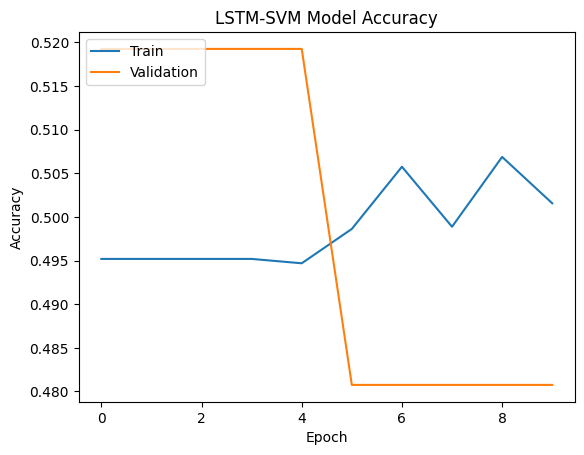

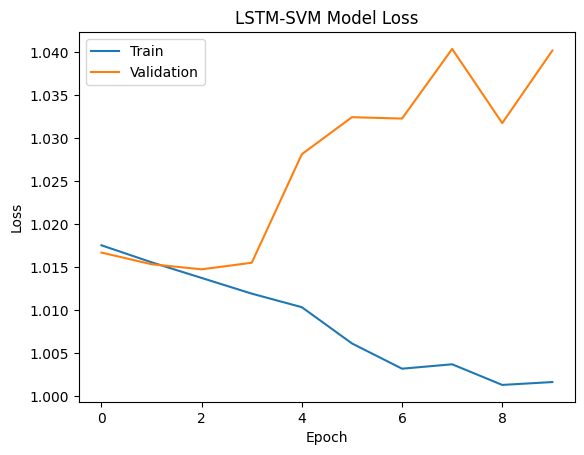

In [121]:
plt.plot(LSTM_SVM_history.history['accuracy'])
plt.plot(LSTM_SVM_history.history['val_accuracy'])
plt.title('LSTM-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img/data_set_1_LSTM_SVM_history_model_accuracy.png', format='png')
plt.show()


plt.plot(LSTM_SVM_history.history['loss'])
plt.plot(LSTM_SVM_history.history['val_loss'])
plt.title('LSTM-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img/data_set_1_LSTM_SVM_model_loss.png', format='png')
plt.show()

**Saving the LSTM-SVM model**

In [123]:
#LSTM_SVM_model.save('saved_model/LSTM_SVM_Model')

**Loading the LSTM-SVM model**

In [124]:
#LSTM_SVM_saved_model = tf.keras.models.load_model('saved_model/LSTM_SVM_Model')

# Training the Bidirectional LSTM-SVM Model

**Creating the Bidirectional LSTM-SVM Model**

In [125]:
BILSTM_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(128), return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(128))),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [126]:
BILSTM_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
print(BILSTM_SVM_model.summary())

**Training the Bidirectional LSTM-SVM model**

In [128]:
number_of_epochs = 10
batch_size = 256

BILSTM_SVM_history = BILSTM_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 314s 5s/step - accuracy: 0.4968 - loss: 1.0122 - val_accuracy: 0.5197 - val_loss: 0.9528
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step - accuracy: 0.5459 - loss: 0.8973 - val_accuracy: 0.6580 - val_loss: 0.7821
Epoch 3/10
 5/63 ━━━━━━━━━━━━━━━━━━━━ 4:37 5s/step - accuracy: 0.6392 - loss: 0.7757

KeyboardInterrupt: 

**Plotting the Bidirectional LSTM-SVM train graph**

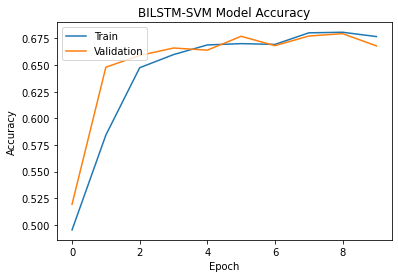

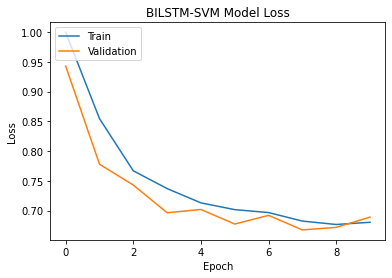

In [ ]:
plt.plot(BILSTM_SVM_history.history['accuracy'])
plt.plot(BILSTM_SVM_history.history['val_accuracy'])
plt.title('BILSTM-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img/data_set_1_BILSTM_SVM_model_accuracy.png', format='png')
plt.show()


plt.plot(BILSTM_SVM_history.history['loss'])
plt.plot(BILSTM_SVM_history.history['val_loss'])
plt.title('BILSTM-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img/data_set_1_BILSTM_SVM_model_loss.png', format='png')
plt.show()

**Saving the Bidirectional LSTM-SVM model**

In [129]:
#BILSTM_SVM_model.save('saved_model/BILSTM_SVM_Model')

**Loading the Bidirectional LSTM-SVM model**

In [130]:
#BILSTM_SVM_saved_model = tf.keras.models.load_model('saved_model/BILSTM_SVM_Model')

# Training the GRU-SVM Model

**Creating the GRU-SVM Model**

In [131]:
GRU_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.GRU((128), return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.GRU((128)),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [132]:
GRU_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [133]:
print(GRU_SVM_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     4,197,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,197,300 (16.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,197,300 (16.01 MB)

None


**Training the GRU-SVM model**

In [134]:
number_of_epochs = 10
batch_size = 256

GRU_SVM_history = GRU_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.4938 - loss: 1.0212 - val_accuracy: 0.5192 - val_loss: 1.0196
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.5000 - loss: 1.0190 - val_accuracy: 0.5192 - val_loss: 1.0176
Epoch 3/10
 3/63 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.5378 - loss: 1.0177

KeyboardInterrupt: 

**Plotting the GRU-SVM train graph**

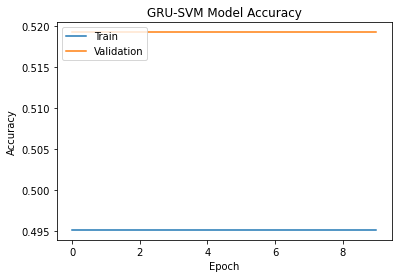

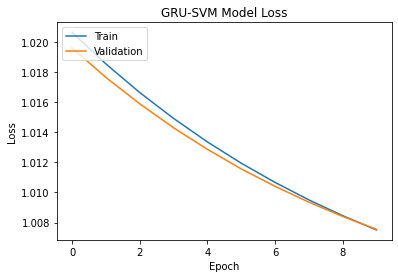

In [ ]:
plt.plot(GRU_SVM_history.history['accuracy'])
plt.plot(GRU_SVM_history.history['val_accuracy'])
plt.title('GRU-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img/data_set_1_GRU_SVM_model_accuracy.png', format='png')
plt.show()

plt.plot(GRU_SVM_history.history['loss'])
plt.plot(GRU_SVM_history.history['val_loss'])
plt.title('GRU-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img/data_set_1_GRU_SVM_model_loss.png', format='png')
plt.show()

**Saving the GRU-SVM model**

In [135]:
#GRU_SVM_model.save('saved_model/GRU_SVM_Model')

**Loading the GRU-SVM model**

In [136]:
#GRU_SVM_saved_model = tf.keras.models.load_model('saved_model/GRU_SVM_Model')

# Training the Bidirectional GRU-SVM Model

**Creating the Bidirectional GRU-SVM Model**

In [137]:
BIGRU_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.GRUCell(128), return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.GRUCell(128))),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [138]:
BIGRU_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
print(BIGRU_SVM_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 280, 300)          4197300   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 280, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 280, 256)          330240    
_________________________________________________________________
dropout_6 (Dropout)          (None, 280, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)              

**Training the Bidirectional GRU-SVM model**

In [ ]:
number_of_epochs = 10
batch_size = 256

BIGRU_SVM_history = BIGRU_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/10
63/63 [==============================] - 142s 2s/step - loss: 1.0111 - accuracy: 0.4972 - val_loss: 0.9445 - val_accuracy: 0.5195
Epoch 2/10
63/63 [==============================] - 135s 2s/step - loss: 0.9345 - accuracy: 0.5141 - val_loss: 0.8144 - val_accuracy: 0.6327
Epoch 3/10
63/63 [==============================] - 137s 2s/step - loss: 0.8241 - accuracy: 0.6145 - val_loss: 0.7806 - val_accuracy: 0.6522
Epoch 4/10
63/63 [==============================] - 136s 2s/step - loss: 0.7902 - accuracy: 0.6300 - val_loss: 0.7591 - val_accuracy: 0.6618
Epoch 5/10
63/63 [==============================] - 137s 2s/step - loss: 0.7738 - accuracy: 0.6423 - val_loss: 0.7485 - val_accuracy: 0.6647
Epoch 6/10
63/63 [==============================] - 139s 2s/step - loss: 0.7604 - accuracy: 0.6520 - val_loss: 0.7489 - val_accuracy: 0.6770
Epoch 7/10
63/63 [==============================] - 136s 2s/step - loss: 0.7449 - accuracy: 0.6635 - val_loss: 0.7331 - val_accuracy: 0.6777
Epoch 8/10
63

**Plotting the Bidirectional GRU-SVM train graph**

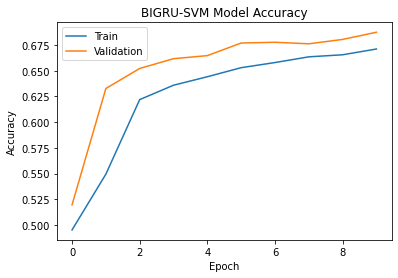

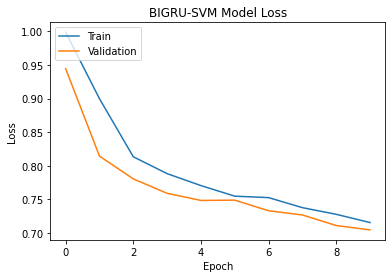

In [ ]:
plt.plot(BIGRU_SVM_history.history['accuracy'])
plt.plot(BIGRU_SVM_history.history['val_accuracy'])
plt.title('BIGRU-SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img/data_set_1_BIGRU_SVM_model_accuracy.png', format='png')
plt.show()


plt.plot(BIGRU_SVM_history.history['loss'])
plt.plot(BIGRU_SVM_history.history['val_loss'])
plt.title('BIGRU-SVM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('img/data_set_1_BIGRU_SVM_model_loss.png', format='png')
plt.show()

**Saving the Bidirectional GRU-SVM model**

In [ ]:
#BIGRU_SVM_model.save('saved_model/BIGRU_SVM_Model')

**Loading the Bidirectional GRU-SVM model**

In [ ]:
#BIGRU_SVM_saved_model = tf.keras.models.load_model('saved_model/BIGRU_SVM_Model')

# Stage 8: Accuracy Analysis

# LSTM-SVM Accuracy Analysis

**Test accuracy and loss**

In [ ]:
test_loss, test_acc = LSTM_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

125/125 [==============================] - 2s 13ms/step - loss: 1.0354 - accuracy: 0.4807
Test Loss: 1.0354194641113281
Test Accuracy: 0.4807499945163727


**Testing the hybrid model against the testing data set**

In [ ]:
LSTM_SVM_scores = LSTM_SVM_model.predict(x_test, verbose=1, batch_size=256)

16/16 [==============================] - 1s 41ms/step


In [ ]:
LSTM_SVM_scores

array([[0.7108087],
       [0.7108087],
       [0.7108087],
       ...,
       [0.7108087],
       [0.7108087],
       [0.7108087]], dtype=float32)

In [ ]:
LSTM_SVM_y_pred=np.where(LSTM_SVM_scores>0.5,1,0)

In [ ]:
LSTM_SVM_y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

**Accuracy**

In [ ]:
print(accuracy_score(y_test, LSTM_SVM_y_pred))

0.48075


**Classification report (Precision, Recall, F1-Score and Accuracy)**

In [ ]:
print(classification_report(y_test, LSTM_SVM_y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2077
           1       0.48      1.00      0.65      1923

    accuracy                           0.48      4000
   macro avg       0.24      0.50      0.32      4000
weighted avg       0.23      0.48      0.31      4000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Confusion Matrix**

In [ ]:
LSTM_SVM_CM=confusion_matrix(y_test, LSTM_SVM_y_pred)
print(LSTM_SVM_CM)

[[   0 2077]
 [   0 1923]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[   0 2077]
 [   0 1923]]


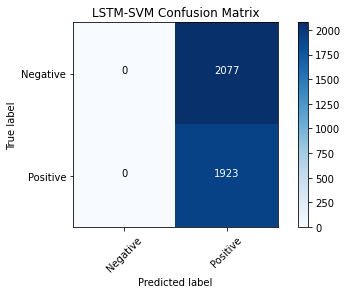

In [ ]:
categories = ['Negative','Positive']
LSTM_SVM_cnf_matrix = confusion_matrix(y_test, LSTM_SVM_y_pred)
plot_confusion_matrix(cm=LSTM_SVM_cnf_matrix, classes=categories, title='LSTM-SVM Confusion Matrix')
#plt.savefig('img/data_set_1_LSTM_SVM_CM.png', format='png')
plt.show()

# Bidirectional LSTM-SVM Accuracy Analysis

**Test accuracy and loss**

In [ ]:
test_loss, test_acc = BILSTM_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

125/125 [==============================] - 15s 120ms/step - loss: 0.6891 - accuracy: 0.6680
Test Loss: 0.6891470551490784
Test Accuracy: 0.6679999828338623


**Testing the hybrid model against the testing data set**

In [ ]:
BILSTM_SVM_scores = BILSTM_SVM_model.predict(x_test, verbose=1, batch_size=256)

16/16 [==============================] - 3s 155ms/step


In [ ]:
BILSTM_SVM_scores

array([[-0.92896235],
       [-0.8723472 ],
       [-0.8348611 ],
       ...,
       [-0.825223  ],
       [-1.0037596 ],
       [ 0.9699156 ]], dtype=float32)

In [ ]:
BILSTM_SVM_y_pred=np.where(BILSTM_SVM_scores>0.5,1,0)

In [ ]:
BILSTM_SVM_y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

**Accuracy**

In [ ]:
print(accuracy_score(y_test, BILSTM_SVM_y_pred))

0.668


**Classification report (Precision, Recall, F1-Score and Accuracy)**

In [ ]:
print(classification_report(y_test, BILSTM_SVM_y_pred))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71      2077
           1       0.70      0.54      0.61      1923

    accuracy                           0.67      4000
   macro avg       0.67      0.66      0.66      4000
weighted avg       0.67      0.67      0.66      4000



**Confusion Matrix**

In [ ]:
BILSTM_SVM_CM=confusion_matrix(y_test, BILSTM_SVM_y_pred)
print(BILSTM_SVM_CM)

[[1633  444]
 [ 884 1039]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[1633  444]
 [ 884 1039]]


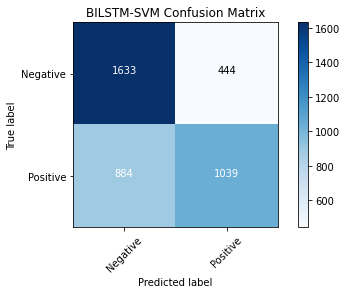

In [ ]:
categories = ['Negative','Positive']
BILSTM_SVM_cnf_matrix = confusion_matrix(y_test, BILSTM_SVM_y_pred)
plot_confusion_matrix(cm=BILSTM_SVM_cnf_matrix, classes=categories, title='BILSTM-SVM Confusion Matrix')
#plt.savefig('img/data_set_1_BILSTM_SVM_CM.png', format='png')
plt.show()

# GRU-SVM Accuracy Analysis

**Test accuracy and loss**

In [ ]:
test_loss, test_acc = GRU_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

125/125 [==============================] - 2s 13ms/step - loss: 1.0076 - accuracy: 0.5192
Test Loss: 1.0075507164001465
Test Accuracy: 0.5192499756813049


**Testing the hybrid model against the testing data set**

In [ ]:
GRU_SVM_scores = GRU_SVM_model.predict(x_test, verbose=1, batch_size=256)

16/16 [==============================] - 1s 37ms/step


In [ ]:
GRU_SVM_scores

array([[0.01016284],
       [0.01016284],
       [0.01016284],
       ...,
       [0.01016284],
       [0.01016284],
       [0.01016284]], dtype=float32)

In [ ]:
GRU_SVM_y_pred=np.where(GRU_SVM_scores>0.5,1,0)

In [ ]:
GRU_SVM_y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

**Accuracy**

In [ ]:
print(accuracy_score(y_test, GRU_SVM_y_pred))

0.51925


**Classification report (Precision, Recall, F1-Score and Accuracy)**

In [ ]:
print(classification_report(y_test, GRU_SVM_y_pred))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      2077
           1       0.00      0.00      0.00      1923

    accuracy                           0.52      4000
   macro avg       0.26      0.50      0.34      4000
weighted avg       0.27      0.52      0.35      4000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Confusion Matrix**

In [ ]:
GRU_SVM_CM=confusion_matrix(y_test, GRU_SVM_y_pred)
print(GRU_SVM_CM)

[[2077    0]
 [1923    0]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[2077    0]
 [1923    0]]


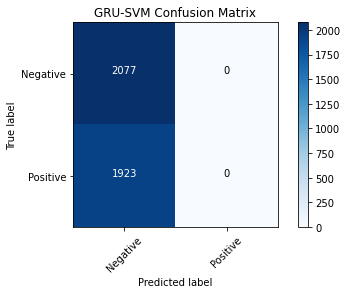

In [ ]:
categories = ['Negative','Positive']
GRU_SVM_cnf_matrix = confusion_matrix(y_test, GRU_SVM_y_pred)
plot_confusion_matrix(cm=GRU_SVM_cnf_matrix, classes=categories, title='GRU-SVM Confusion Matrix')
#plt.savefig('img/data_set_1_GRU_SVM_CM.png', format='png')
plt.show()

# Bidirectional GRU-SVM Accuracy Analysis

**Test accuracy and loss**

In [ ]:
test_loss, test_acc = BIGRU_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

125/125 [==============================] - 19s 144ms/step - loss: 0.7046 - accuracy: 0.6875
Test Loss: 0.704596757888794
Test Accuracy: 0.6875


**Testing the hybrid model against the testing data set**

In [ ]:
BIGRU_SVM_scores = BIGRU_SVM_model.predict(x_test, verbose=1, batch_size=256)

16/16 [==============================] - 3s 171ms/step


In [ ]:
BIGRU_SVM_scores

array([[-0.7944299 ],
       [-0.05519956],
       [-0.21994044],
       ...,
       [ 0.06563546],
       [-1.3814718 ],
       [ 1.213371  ]], dtype=float32)

In [ ]:
BIGRU_SVM_y_pred=np.where(BIGRU_SVM_scores>0.5,1,0)

In [ ]:
BIGRU_SVM_y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

**Accuracy**

In [ ]:
print(accuracy_score(y_test, BIGRU_SVM_y_pred))

0.6875


**Classification report (Precision, Recall, F1-Score and Accuracy)**

In [ ]:
print(classification_report(y_test, BIGRU_SVM_y_pred))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      2077
           1       0.68      0.66      0.67      1923

    accuracy                           0.69      4000
   macro avg       0.69      0.69      0.69      4000
weighted avg       0.69      0.69      0.69      4000



**Confusion Matrix**

In [ ]:
BIGRU_SVM_CM=confusion_matrix(y_test, BIGRU_SVM_y_pred)
print(BIGRU_SVM_CM)

[[1474  603]
 [ 647 1276]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[1474  603]
 [ 647 1276]]


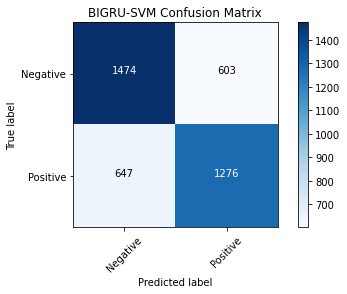

In [ ]:
categories = ['Negative','Positive']
BIGRU_SVM_cnf_matrix = confusion_matrix(y_test, BIGRU_SVM_y_pred)
plot_confusion_matrix(cm=BIGRU_SVM_cnf_matrix, classes=categories, title='BIGRU-SVM Confusion Matrix')
#plt.savefig('img/data_set_1_BIGRU_SVM_CM.png', format='png')
plt.show()

# Stage 9: Testing Class

Five user created English sentences will be used to evaluate if the hybrid models is able to distinguish between positive and negative text.

* 1st sentence is a positive tweet
* 2nd sentence is a negative tweet
* 3rd sentence is a sarcastic tweet
* 4th sentence is a neutral tweet
* 5th sentence is a scary joke tweet

# LSTM-SVM Testing Class

**Testing the LSTM-SVM model by using a basic test function**

In [ ]:
test_sentence1 = [ "The flight was amazing #POG. I will fly again because it was exquisite and the bathtub was ok :)", 
                  "This REEESUBHUMAN political party are absolutely horrible, racist, dumb and rude >:(", 
                  "Hope they get nuked. such an uncvis.ised uvu twats booooooo you stink lol XD", 
                  "This game called Destiny it's alright, it provides decent loot and ok rewards. I will play it again with my friends", 
                  "Bruh, Imma SSJ3 kamehameha those dementors from Harry Potter because they are scary. "]


#Converting the sentences to sequences using a tokenizer
test_sequences1 = tokenizer.texts_to_sequences(test_sentence1)

#Padding the new sequences to make them have the same dimension
test_padded1 = pad_sequences(test_sequences1, maxlen = max_word_length, 
                             padding = padding_type, truncating = trunc_type)

#Testing out the new padded data on a trained LSTM-SVM model
test_padded1 = np.array(test_padded1)
print(LSTM_SVM_model.predict(test_padded1))

[[0.7108087]
 [0.7108087]
 [0.7108087]
 [0.7108087]
 [0.7108087]]


# Bidirectional LSTM-SVM Testing Class

**Testing the Bidirectional LSTM-SVM model by using a basic test function**

In [ ]:
test_sentence2 = [ "The flight was amazing #POG. I will fly again because it was exquisite and the bathtub was ok :)", 
                  "This REEESUBHUMAN political party are absolutely horrible, racist, dumb and rude >:(", 
                  "Hope they get nuked. such an uncvis.ised uvu twats booooooo you stink lol XD", 
                  "This game called Destiny it's alright, it provides decent loot and ok rewards. I will play it again with my friends", 
                  "Bruh, Imma SSJ3 kamehameha those dementors from Harry Potter because they are scary. "]


#Converting the sentences to sequences using tokenizer
test_sequences2 = tokenizer.texts_to_sequences(test_sentence2)

#Padding the new sequences to make them have same dimensions
test_padded2 = pad_sequences(test_sequences2, maxlen = max_word_length, 
                             padding = padding_type, truncating = trunc_type)

#Testing out the new padded data on a trained Bidirectional LSTM-SVM model
test_padded2 = np.array(test_padded2)
print(BILSTM_SVM_model.predict(test_padded2))

[[-0.5571143 ]
 [-0.811026  ]
 [-0.6885232 ]
 [-0.80623233]
 [ 1.081904  ]]


# GRU-SVM Testing Class

**Testing the GRU-SVM model by using a basic test function**

In [ ]:
test_sentence3 = [ "The flight was amazing #POG. I will fly again because it was exquisite and the bathtub was ok :)", 
                  "This REEESUBHUMAN political party are absolutely horrible, racist, dumb and rude >:(", 
                  "Hope they get nuked. such an uncvis.ised uvu twats booooooo you stink lol XD", 
                  "This game called Destiny it's alright, it provides decent loot and ok rewards. I will play it again with my friends", 
                  "Bruh, Imma SSJ3 kamehameha those dementors from Harry Potter because they are scary."]


# Converting the sentences to sequences using tokenizer
test_sequences3 = tokenizer.texts_to_sequences(test_sentence3)

# padding the new sequences to make them have same dimensions
test_padded3 = pad_sequences(test_sequences3, maxlen = max_word_length, 
                             padding = padding_type, truncating = trunc_type)

#Testing out the new padded data on a trained GRU-SVM model
test_padded3 = np.array(test_padded3)
print(GRU_SVM_model.predict(test_padded3))

[[0.01016284]
 [0.01016284]
 [0.01016284]
 [0.01016284]
 [0.01016284]]


# Bidirectional GRU-SVM Testing Class

**Testing the Bidirectional GRU-SVM model by using a basic test function**

In [ ]:
test_sentence4 = [ "The flight was amazing #POG. I will fly again because it was exquisite and the bathtub was ok :)", 
                  "This REEESUBHUMAN political party are absolutely horrible, racist, dumb and rude >:(", 
                  "Hope they get nuked. such an uncvis.ised uvu twats booooooo you stink lol XD", 
                  "This game called Destiny it's alright, it provides decent loot and ok rewards. I will play it again with my friends", 
                  "Bruh, Imma SSJ3 kamehameha those dementors from Harry Potter because they are scary."]


# Converting the sentences to sequences using tokenizer
test_sequences4 = tokenizer.texts_to_sequences(test_sentence4)

# padding the new sequences to make them have same dimensions
test_padded4 = pad_sequences(test_sequences4, maxlen = max_word_length, 
                             padding = padding_type, truncating = trunc_type)

#Testing out the new padded data on a trained BIGRU-SVM model
test_padded4 = np.array(test_padded4)
print(BIGRU_SVM_model.predict(test_padded4))

[[ 0.3015033 ]
 [-0.05600158]
 [ 0.10142963]
 [ 0.36992395]
 [ 1.1990848 ]]


# Conclusion

The Bidirectional GRU-SVM model is the best model to use to detect human emotion in Twitter text tweets. This model can understand positive, negative, neutral, and sarcastic sentences but fails to understand a scary joke sentence compared to the Bidirectional LSTM-SVM model which is able to detect only neutral and the negative sentences. This is possible because the Bidirectional GRU-SVM model GRU model has 2 gates which are the update and reset gate compared to the Bidirectional LSTM-SVM model LSTM model which has 3 gates and they are the input, forget and output gates. This simplicity is the GRU main benefit combined with the SVM optimal hyperplanes which is designed for the separation of training data without errors and soft margins which allows for an analytic treatment of learning with errors on the training set compared to the LSTM model which are complex with 3 gates.